In [1]:
import numpy as np
import h5py
import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import Input, Embedding
from keras.layers import Dense, Merge, Dropout
from keras.layers import LSTM, Bidirectional
from keras import metrics
from keras import backend as K
from keras.layers import Lambda
import pickle

/home/alisay/tensor_flow_py3/lib/python3.4/importlib/_bootstrap.py:321: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return f(*args, **kwds)
Using TensorFlow backend.


In [2]:
alphabet = "NACGT"
vocab_size = len(alphabet)
time_steps = 100
embedding_size = 300 # for embedding layer, maybe remove
dense_size = 300
category = 10 # size of Y_vector

genome_input_shape = (100,)

def create_base_network(input_shape):
    input = Input(shape=input_shape)
    x = Embedding(vocab_size, embedding_size, input_length=time_steps)(input)
    x = Bidirectional(LSTM(units=300, return_sequences=True))(x)
    x = Dropout(0.50)(x)
    x = Bidirectional(LSTM(units=300))(x)
    x = Dropout(0.50)(x)

    x = Dense(dense_size, activation='relu')(x)
    x = Dense(dense_size, activation='relu')(x)
    x = Dense(category, activation='linear')(x)
    return Model(input, x)


model_makes_embedding = create_base_network(genome_input_shape)

input_a = Input(shape=genome_input_shape)
input_b = Input(shape=genome_input_shape)

processed_a = model_makes_embedding(input_a)
processed_b = model_makes_embedding(input_b)

merged_vector = keras.layers.concatenate([processed_a, processed_b])
x = Dense(dense_size, activation='relu')(merged_vector)
out = Dense(1, activation='sigmoid')(x)

model_pairs_pos_neg = Model([input_a, input_b], out)

model_pairs_pos_neg.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_pairs_pos_neg.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 100)           0                                            
____________________________________________________________________________________________________
input_3 (InputLayer)             (None, 100)           0                                            
____________________________________________________________________________________________________
model_1 (Model)                  (None, 10)            3879910                                      
____________________________________________________________________________________________________
concatenate_1 (Concatenate)      (None, 20)            0                                            
___________________________________________________________________________________________

In [3]:
h5f = h5py.File('X_train_pairs_pos_neg_a.h5','r')
X_train_a = h5f['X_a'][:]
h5f.close()
h5f = h5py.File('X_train_pairs_pos_neg_b.h5','r')
X_train_b = h5f['X_b'][:]
h5f.close()
h5f = h5py.File('Y_train_pairs_pos_neg.h5','r')
Y_train = h5f['Y'][:]
h5f.close()
print(X_train_a.shape)
print(Y_train.shape)
print(X_train_a[1000:1001])
print(X_train_b[1000:1001])
print(Y_train[:10])
h5f = h5py.File('X_test_pairs_pos_neg_a.h5','r')
X_test_a = h5f['X_a'][:]
h5f.close()
h5f = h5py.File('X_test_pairs_pos_neg_b.h5','r')
X_test_b = h5f['X_b'][:]
h5f.close()
h5f = h5py.File('Y_test_pairs_pos_neg.h5','r')
Y_test = h5f['Y'][:]
h5f.close()

(99182, 100)
(99182,)
[[2 3 2 4 3 1 4 3 2 1 2 3 1 1 1 3 2 3 4 3 3 3 3 1 3 2 1 1 1 2 1 3 3 1 4 4
  1 3 1 4 1 2 2 2 4 3 3 4 1 3 4 2 2 1 2 3 2 2 3 4 1 1 1 2 3 1 4 3 1 3 4 3
  2 4 1 3 1 4 1 4 2 3 3 1 1 3 1 4 4 2 4 2 4 4 4 2 3 3 4 4]]
[[3 2 3 3 4 3 3 1 3 4 1 4 3 4 3 3 4 4 4 1 1 4 4 2 3 1 2 3 2 1 1 2 3 2 3 1
  1 3 1 1 2 2 4 4 1 2 2 1 3 3 3 2 4 4 3 1 2 1 4 2 3 2 3 2 3 1 2 1 3 2 4 2
  4 1 3 1 3 1 4 1 3 1 3 3 3 4 4 2 4 3 2 2 4 4 1 3 3 3 4 1]]
[1 1 0 1 1 1 1 0 1 0]


In [6]:
model_pairs_pos_neg.fit([X_train_a[:10], X_train_b[:10]], Y_train[:10], validation_data=([X_test_a[:10], X_test_b[:10]], Y_test[:10]), batch_size=128)

Train on 10 samples, validate on 10 samples
Epoch 1/1
10/10 [==============================] - 5s - loss: 0.6796 - acc: 0.7000 - val_loss: 0.6029 - val_acc: 1.0000


{'loss': [0.6939276200101783, 0.6933943183446944, 0.6932438547260611, 0.693246684206902, 0.6931923478706565], 'val_loss': [0.693960214525212, 0.6932505313552344, 0.6930983159721533, 0.6931079619150603, 0.6930955784384774], 'acc': [0.5008065979702042, 0.5032263918814177, 0.5024903712343125, 0.5018551753714937, 0.503801092960684], 'val_acc': [0.504950495049505, 0.504950495049505, 0.504950495049505, 0.504950495049505, 0.504950495049505]}
{'loss': [0.6932802259127555, 0.6931636284042435, 0.6931168800093503, 0.6931675654430143, 0.6931707846106597], 'val_loss': [0.6931072422532889, 0.6931003187753072, 0.6930982078381093, 0.6931166438360599, 0.6930982155329125], 'acc': [0.5025307010872097, 0.5035288661206949, 0.5043152991758688, 0.5044161238742176, 0.5034381238639358], 'val_acc': [0.504950495049505, 0.504950495049505, 0.504950495049505, 0.504950495049505, 0.504950495049505]}
{'loss': [0.6931396533983237, 0.6931329643127069, 0.6931790465276477, 0.6931227544160238, 0.6931062555880899], 'val_los

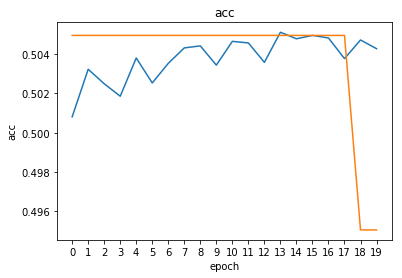

In [6]:
%matplotlib inline
import pickle
import numpy as np
import matplotlib.pyplot as plt
#plt.plot(history_epoch_1_50_100K['mean_squared_error'] + history_epoch_50_100_100K['mean_squared_error'])
#plt.plot(history_epoch_1_50_100K['val_mean_squared_error'] + history_epoch_50_100_100K['val_mean_squared_error'])
acc = []
val_acc = []
for myset in range(1,5):
    with open('Jan26_model_pairs_pos_neg_set' + str(myset) + '_history.txt', 'rb') as handle:
        saved_history = pickle.loads(handle.read())
        acc += saved_history['acc']
        val_acc += saved_history['val_acc']
        print(saved_history)
print("loaded")
plt.plot(acc)
plt.plot(val_acc)
plt.title('acc')
plt.xticks(np.arange(0, 20, 1))
plt.ylabel('acc')
plt.xlabel('epoch')